In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import json
import joblib

In [2]:
df = pd.read_csv("../dataset/clustering_dokumen/dataset.csv")
data_text = df['dokumen'].astype(str)

print("Contoh data:")
print(data_text.head())

Contoh data:
0    Panduan pembayaran UKT melalui virtual account...
1    Pembayaran registrasi dapat dilakukan melalui ...
2    Biaya pendaftaran mahasiswa baru sebesar Rp 30...
3    Prosedur pembayaran remidi menggunakan kode kh...
4    Informasi biaya pendidikan lengkap tersedia di...
Name: dokumen, dtype: object


In [3]:
with open('stopwords_custom.json', 'r', encoding='utf-8') as f:
    stopwords_custom = json.load(f)

vectorizer = TfidfVectorizer(
    max_features=100,  # Kurangi fitur untuk fokus kata penting
    ngram_range=(1, 3),  # Tambah trigram untuk context lebih
    min_df=5,  # Kata harus muncul min 3 dokumen
    max_df=0.6,  # Kata tidak boleh di >60% dokumen
    stop_words=stopwords_custom
)

# Transformasi data
X_vector = vectorizer.fit_transform(data_text)


print(f"Ukuran Matriks: {X_vector.shape}")

Ukuran Matriks: (350, 90)


/opt/homebrew/Caskroom/miniconda/base/envs/jokichatbot/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'siap', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [4]:
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_vector)
    sil = silhouette_score(X_vector, labels, metric="cosine")
    print(f"k={k} | silhouette(cosine)={sil:.4f}")


k=2 | silhouette(cosine)=0.0659
k=3 | silhouette(cosine)=0.0826
k=4 | silhouette(cosine)=0.1035
k=5 | silhouette(cosine)=0.1200
k=6 | silhouette(cosine)=0.1487
k=7 | silhouette(cosine)=0.1901
k=8 | silhouette(cosine)=0.1677
k=9 | silhouette(cosine)=0.1828
k=10 | silhouette(cosine)=0.1892


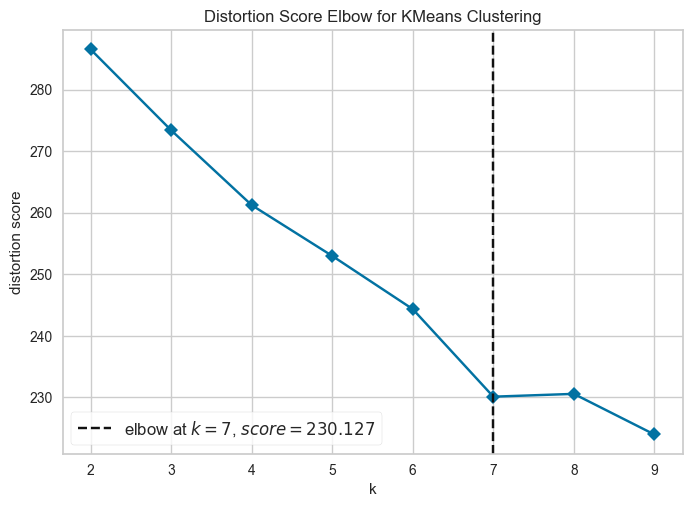

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)
visualizer.fit(X_vector.toarray())
visualizer.show()

In [6]:
cluster = 7
# Inisialisasi K-Means
kmeans = KMeans(
    n_clusters= cluster, 
    random_state=42, 
    n_init=10
)
df["cluster"] = kmeans.fit_predict(X_vector)

df[["dokumen", "cluster"]].head()

,dokumen,cluster
0,Panduan pembayaran UKT melalui virtual account...,2
1,Pembayaran registrasi dapat dilakukan melalui ...,2
2,Biaya pendaftaran mahasiswa baru sebesar Rp 30...,3
3,Prosedur pembayaran remidi menggunakan kode kh...,2
4,Informasi biaya pendidikan lengkap tersedia di...,3


In [7]:
feature_names = np.array(vectorizer.get_feature_names_out())
centroids = kmeans.cluster_centers_

top_n = 10
print("--- TOPIK PER CLUSTER ---")
for i in range(kmeans.n_clusters):
    top_idx = centroids[i].argsort()[::-1][:top_n]
    top_words = feature_names[top_idx]
    print(f"Cluster {i}: {', '.join(top_words)}")


--- TOPIK PER CLUSTER ---
Cluster 0: dosen, konsultasi, akademik, fakultas, mengikuti, prestasi, aktif, program, dihubungi, wali
Cluster 1: tersedia, area, semarang, beasiswa, program, sistem, bca, lantai, fasilitas, mata
Cluster 2: pembayaran, account, virtual account, virtual, bank, ukt, kode, khusus, biku, nomor
Cluster 3: sistem, fakultas, program, studi, pendaftaran, biaya, akademik, pmb, program studi, email
Cluster 4: akun, password, aktivasi, tutorial, komputer, keamanan, btik, akses, email, helpdesk
Cluster 5: krs, jadwal, pengisian, akademik, pengisian krs, wali, dosen wali, dosen, siadin, prodi
Cluster 6: beasiswa, prestasi, biaya, berprestasi, biaya pendidikan, pendidikan, akademik, aktif, minimal, website


In [8]:
def prediksi_cluster(teks_baru):
    # 1. Ubah ke vektor (pakai .transform, jangan fit)
    vec = vectorizer.transform([teks_baru])
    
    # 2. Prediksi masuk cluster mana
    cluster_id = kmeans.predict(vec)[0]
    return cluster_id

# Coba tes
input_user = "bagaimana proses pendaftaran?"
hasil_cluster = prediksi_cluster(input_user)

print(f"Pertanyaan: '{input_user}'")
print(f"Masuk ke Cluster: {hasil_cluster}")

Pertanyaan: 'bagaimana proses pendaftaran?'
Masuk ke Cluster: 3


In [9]:
X_dense = X_vector.toarray()
labels = kmeans.labels_

print(f"--- Evaluasi untuk k={cluster} ---")
sil_score = silhouette_score(X_dense, labels)
print(f"Silhouette Score       : {sil_score:.4f}")
db_index = davies_bouldin_score(X_dense, labels)
print(f"Davies-Bouldin Index   : {db_index:.4f}")
ch_index = calinski_harabasz_score(X_dense, labels)
print(f"Calinski-Harabasz Index: {ch_index:.4f}")

--- Evaluasi untuk k=7 ---
Silhouette Score       : 0.1511
Davies-Bouldin Index   : 2.4011
Calinski-Harabasz Index: 17.8956


In [10]:
# Mendapatkan feature names (kata-kata yang dipilih TF-IDF)
feature_names = np.array(vectorizer.get_feature_names_out())
centroids = kmeans.cluster_centers_

# Menyimpan kata-kata utama di setiap cluster
top_n = 8
cluster_keywords = {}

# Menyimpan keyword utama per cluster
for i in range(kmeans.n_clusters):
    top_idx = centroids[i].argsort()[::-1][:top_n]
    cluster_keywords[i] = ", ".join(feature_names[top_idx])

# Menyesuaikan cluster_label dengan cluster_map yang sudah ditentukan
cluster_map = {
    0: "INFORMASI_DOSEN",   
    1: "PENDAFTARAN_PMB",    
    2: "ADMINISTRASI_KEUANGAN",  
    3: "FASILITAS_KAMPUS",   
    4: "TEKNIS_AKUN",        
    5: "AKADEMIK_KRS",       
    6: "BEASISWA",           
}

# Menyesuaikan label cluster dengan cluster_map
cluster_label = {i: cluster_map[i] for i in cluster_map}

# Menampilkan hasil cluster_label
print(cluster_label)


{0: 'INFORMASI_DOSEN', 1: 'PENDAFTARAN_PMB', 2: 'ADMINISTRASI_KEUANGAN', 3: 'FASILITAS_KAMPUS', 4: 'TEKNIS_AKUN', 5: 'AKADEMIK_KRS', 6: 'BEASISWA'}


In [11]:
X = X_vector
centers = kmeans.cluster_centers_
labels = df["cluster"].values

# jarak tiap dokumen ke centroid clusternya
# (KMeans default: euclidean di ruang TF-IDF)
dist = np.zeros(X.shape[0])

for i in range(kmeans.n_clusters):
    idx = np.where(labels == i)[0]
    if len(idx) == 0:
        continue
    # hitung jarak manual dengan dot trick (aman untuk sparse)
    Xi = X[idx]
    ci = centers[i]
    # ||x - c||^2 = ||x||^2 + ||c||^2 - 2 x·c
    x_norm2 = Xi.multiply(Xi).sum(axis=1).A1
    c_norm2 = np.dot(ci, ci)
    x_dot_c = Xi @ ci
    dist[idx] = np.sqrt(x_norm2 + c_norm2 - 2 * np.array(x_dot_c).ravel())

df["dist_to_centroid"] = dist

# ambil 3 dokumen terdekat per cluster
for i in range(kmeans.n_clusters):
    sample = df[df["cluster"] == i].nsmallest(3, "dist_to_centroid")
    print(f"\nCluster {i} | label: {cluster_label[i]}")
    for j, row in sample.iterrows():
        print("-", row["dokumen"][:160], "...")



Cluster 0 | label: INFORMASI_DOSEN
- Kelas penuh dapat mengajukan penambahan kuota kepada dosen pengampu ...
- Kuota bimbingan dosen terbatas untuk setiap semester ...
- Mahasiswa harus proaktif menghubungi dosen pembimbing ...

Cluster 1 | label: PENDAFTARAN_PMB
- Kelas karyawan tersedia untuk mahasiswa yang sudah bekerja ...
- Rooftop garden tersedia sebagai tempat santai mahasiswa ...
- Coworking space tersedia untuk belajar kelompok mahasiswa ...

Cluster 2 | label: ADMINISTRASI_KEUANGAN
- Pembayaran dapat dilakukan 24 jam melalui ATM mobile banking atau internet banking ...
- Mahasiswa harus menyimpan bukti pembayaran sebagai dokumen penting ...
- Prosedur pembayaran remidi menggunakan kode khusus 03 pada virtual account pembayaran ...

Cluster 3 | label: FASILITAS_KAMPUS
- Jam pelayanan BIAK Senin Jumat pukul 07.00 sampai 16.00 WIB ...
- Kuota SKS per semester dapat dikonsultasikan kepada Kaprodi ...
- Batas maksimal SKS tergantung pada IPK semester sebelumnya ...

Cluster 4 | l

In [12]:
# simpan
joblib.dump(vectorizer, "../model/model_clustering_dokumen/tfidf_vectorizer.pkl")
joblib.dump(kmeans, "../model/model_clustering_dokumen/kmeans_model.pkl")
joblib.dump(cluster_label, "../model/model_clustering_dokumen/cluster_label.pkl")


print("Saved: tfidf_vectorizer.pkl & kmeans_model.pkl")

Saved: tfidf_vectorizer.pkl & kmeans_model.pkl
